In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from skimage.feature import canny, hog, local_binary_pattern
from skimage.filters import farid, gaussian

In [2]:
# Read the parquet file, this takes a while. Leave it here
dft = pl.read_parquet("Train.parquet", use_pyarrow=True, memory_map=True)

In [22]:
def restore_image_from_list(width: int, height: int, image: list) -> np.array:
    return np.array(image).reshape((height, width, 3))


def image_for_display(image: np.array) -> np.array:
    """
    Convert image to 0-255 range
    """
    return np.clip((image * 256), 0, 255).astype(np.uint8)


def blur_image(image: np.array, sigma=2) -> np.array:
    """
    Blur the image to remove noise
    """
    return gaussian(image, sigma=sigma, channel_axis=-1)


def edge_detection(image: np.array) -> np.array:
    l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    # return farid(l_channel, axis=-1)
    return canny(l_channel, sigma=3)


def convert_to_lab(image: np.array) -> np.array:
    if image.dtype != np.uint8:
        image = image.astype(np.float64) * 255.0
    return cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2LAB)


def create_local_binary_pattern(image: np.array) -> np.array:
    """
    Create the local binary pattern for the image
    """
    l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    return local_binary_pattern(l_channel, 8, 1, method="uniform")


def create_hog_features(image: np.array) -> np.array:
    """
    The best parameters for the HOG features are:
            block_norm="L2-Hys",
            pixels_per_cell=(6, 6),
            cells_per_block=(2, 2),
    There appears to be no difference betwen using the RGB or LAB color space
    Therefore we will use the RGB color space
    The hog image doesn't need to be 0-255 it will work with a normalized image
    as input
    """
    # image = (image * 255).astype(np.uint8)
    # l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    # features_lab, hog_image_lab = hog(
    #    l_channel,
    #    orientations=9,
    #    block_norm="L2-Hys",
    #    pixels_per_cell=(6, 6),
    #    cells_per_block=(2, 2),
    #    visualize=True,
    #    #channel_axis=-1
    # )
    features_rgb, hog_image_rgb = hog(
        image,
        orientations=9,
        block_norm="L2-Hys",
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1,
    )
    return features_rgb, hog_image_rgb


def perform_sift(image: np.array) -> tuple:
    """
    Perform sift on the image
    """
    l_channel, a_channel, b_channel = cv2.split(convert_to_lab(image))
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(l_channel, None)
    return kp, des


def create_hog_features_single(image: np.array) -> np.array:
    """
    The best parameters for the HOG features are:
            block_norm="L2-Hys",
            pixels_per_cell=(6, 6),
            cells_per_block=(2, 2),
    There appears to be no difference betwen using the RGB or LAB color space
    Therefore we will use the RGB color space
    The hog image doesn't need to be 0-255 it will work with a normalized image
    as input
    """
    # image = (image * 255).astype(np.uint8)
    # l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    # features_lab, hog_image_lab = hog(
    #    l_channel,
    #    orientations=9,
    #    block_norm="L2-Hys",
    #    pixels_per_cell=(6, 6),
    #    cells_per_block=(2, 2),
    #    visualize=True,
    #    #channel_axis=-1
    # )
    features_rgb, hog_image_rgb = hog(
        image,
        orientations=9,
        block_norm="L2-Hys",
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        visualize=True,
    )
    return features_rgb, hog_image_rgb


def compute_hsv_histograms(image: np.array) -> np.array:
    """
    Compute the HSV histograms for the image
    """
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_bins = 180
    s_bins = 256
    v_bins = 256

    h_range = [0, 180]
    s_range = [0, 256]
    v_range = [0, 256]

    ranges = [h_range, s_range, v_range]
    hue_hist = cv2.calcHist([hsv_image], [0], None, [h_bins], h_range)
    sat_hist = cv2.calcHist([hsv_image], [1], None, [s_bins], s_range)
    val_hist = cv2.calcHist([hsv_image], [2], None, [v_bins], v_range)
    return hue_hist, sat_hist, val_hist


def compute_lbp_image(image: np.array) -> np.array:
    """
    Compute the LBP image for the image
    """
    radius = 3 
    n_points = 16
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    l_channel, a_channel, b_channel = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2LAB))
    lbp_image = local_binary_pattern(l_channel, n_points, radius, method="uniform")
    return lbp_image

(180, 1)


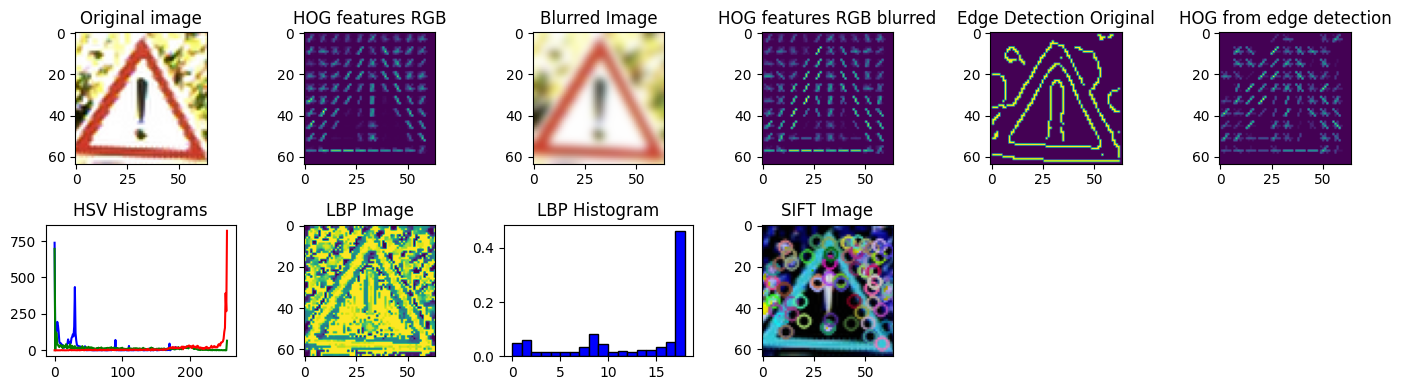

In [33]:
##################################################
##
## HOG seems to work best with the raw image not blurred or not edge detected
##
samples = dft.sample(100, with_replacement=False)

features_rgb, hog_image_rgb = create_hog_features(
    restore_image_from_list(
        samples["Scaled_Width"][0],
        samples["Scaled_Height"][0],
        samples["Stretched_Histogram_Image"][0],
    )
)

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(2, 6, 1)
original_image = image_for_display(
    restore_image_from_list(
        samples["Scaled_Width"][0],
        samples["Scaled_Height"][0],
        samples["Stretched_Histogram_Image"][0],
    )
)
ax.imshow(original_image)
ax.set_title("Original image")


ax = fig.add_subplot(2, 6, 2)
ax.imshow(hog_image_rgb)
ax.set_title("HOG features RGB")
ax = fig.add_subplot(2, 6, 3)
blurred_image = blur_image(
    image_for_display(
        restore_image_from_list(
            samples["Scaled_Width"][0],
            samples["Scaled_Height"][0],
            samples["Stretched_Histogram_Image"][0],
        )
    )
)
ax.imshow(blurred_image)
ax.set_title("Blurred Image")


ax = fig.add_subplot(2, 6, 4)
features_blurred_rgb, hog_blurred_image_rgb = create_hog_features(blurred_image)
ax.imshow(hog_blurred_image_rgb)
ax.set_title("HOG features RGB blurred")


ax = fig.add_subplot(2, 6, 5)
edge_image = edge_detection((original_image * 255).astype(np.uint8))
ax.imshow(edge_image)
ax.set_title("Edge Detection Original")

hog_features, hog_image = create_hog_features_single(edge_image)
ax = fig.add_subplot(2, 6, 6)
ax.imshow(hog_image)
ax.set_title("HOG from edge detection")

hue_hist, sat_hist, val_hist = compute_hsv_histograms(original_image)
ax = fig.add_subplot(2, 6, 7)
ax.plot(hue_hist, color="b", label="Hue")
ax.plot(sat_hist, color="g", label="Saturation")
ax.plot(val_hist, color="r", label="Value")
ax.set_title("HSV Histograms")
print(hue_hist.shape)
lbp_image = compute_lbp_image(original_image)
ax = fig.add_subplot(2, 6, 8)
ax.imshow(lbp_image)
ax.set_title("LBP Image")


lbp_hist, bin_edges = np.histogram(
    lbp_image.ravel().astype(np.uint8), bins=18, range=(0, 18)
)

# Normalize the histogram
lbp_hist = lbp_hist.astype("float")
lbp_hist /= lbp_hist.sum() + 1e-6
ax = fig.add_subplot(2, 6, 9)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#plt.bar(bin_centers, lbp_hist, width=0.8, color="blue", edgecolor="black")
plt.bar(bin_centers, lbp_hist, width=(bin_edges[1]-bin_edges[0]), color="blue", edgecolor="black")
# ax.plot(lbp_hist)
ax.set_title("LBP Histogram")

## Don't think we're going to use the SIFT features
## Leave for historical purposes
kp, desc = perform_sift(original_image)
sift_image = cv2.drawKeypoints((original_image * 255).astype(np.uint8), kp, None)
ax = fig.add_subplot(2, 6, 10)
ax.imshow(sift_image)
ax.set_title("SIFT Image")

plt.tight_layout()
plt.show()